# Iterative Solvers 1 - Krylov subspaces, Arnoldi Iteration and the Full Orthogonalisation Method

In this session we want to introduce the most import class of iterative solvers, namely Krylov subspace methods for the solution of the linear system of equations

$$
Ax = b.
$$

with $A$ a real or complex $n\times n$ matrix. Here, we will assume for simplicity that $A\in\mathbb{R}^{n\times n}$. But all algorithms discussed here can also be extended to the complex case.

The basic assumption is that we are only allowed to perform matrix-vector products with $A$, nothing more. It is remarkable that this operation is enough to develop algorithms that for many classes of problems give us fast converging algorithms to the solution of the above linear system of equations.

## Krylov subspaces and the Arnoldi iteration

We want to approximate the solution to the linear system $Ax=b$ by only being allowed to do matrix-vector products with $A$. The idea is that we use the matrix-vector products to build up a subspace of $\mathbb{R}^n$.

**Definition** (Krylov Subspace)

The Krylov subspace $\mathcal{K}_m(A, b)$ is defined by

$$
\mathcal{K}_m(A, b) := \text{span}\{b, Ab, A^2b, \dots, A^{m-1}b\}.
$$

This subspace collects all the vectors that we can form by combining powers of $A$ times b. Let us try out this subspace numerically.

In [1]:
import numpy as np

def compute_krylov_basis(A, b, m):
    """Generates a numerical basis for the m-dimensional Krylov subspace."""
    n = A.shape[0]
    
    result = np.empty((n, m), dtype=np.float64)
    
    result[:, 0] = b
    
    for index in range(1, m):
        result[:, index] = A @ result[:, index - 1]
        
    return result

An important measure of the usefulness of a basis is its conditioning. It measures how linearly independent vectors are. A condition number close to $1$ means that the basis is well behaved. A condition number close to $10^{16}$ means that the basis is numerically singular (this is related to the fact that standard double precision has around 16 digits of accuracy).

Let us measure the condition number of the Krylov subspace basis as $m$ increases.

In [2]:
n = 100 # Matrix dimension

m_max = 20

rand = np.random.RandomState(0)
A = rand.rand(n, n)
b = rand.rand(n)

krylov_basis = compute_krylov_basis(A, b, m_max)

for m in range(1, m_max):
    cond_number = np.linalg.cond(krylov_basis[:,:m])
    print("{0}: {1:2.1e}".format(m, cond_number))


1: 1.0e+00
2: 8.0e+01
3: 4.0e+03
4: 2.0e+05
5: 1.0e+07
6: 5.0e+08
7: 2.5e+10
8: 1.2e+12
9: 6.1e+13
10: 3.0e+15
11: 6.2e+17
12: 1.1e+19
13: 4.6e+21
14: 2.6e+24
15: 9.7e+23
16: 5.9e+27
17: 1.4e+29
18: 2.0e+29
19: 2.0e+31


This is catastrophic. Already with 10 vectors the Krylov subspace basis is effectively numerically singular. The mathematical reason is that the powers $A^{m}b$ converge to the eigenvector associated with the largest (by magnitude) eigenvalue of $A$. Hence, the later iterates more and more point in the same direction and are not really linearly dependent. We need a way to generate a stable basis for growing $m$. The ideal case is an orthogonal basis, where all basis vectors are pairwise orthogonal to each other and of unit length.

This is accomplished by the following modified algorithm that after each multiplication with the matrix $A$ orthogonalizes the new vector against all previous vectors.

In [3]:
import numpy as np

def compute_krylov_basis_orthogonal(A, b, m):
    """Generates an orthogonal basis for the m-dimensional Krylov subspace."""
    n = A.shape[0]
    
    result = np.empty((n, m), dtype=np.float64)
    
    result[:, 0] = b / np.linalg.norm(b)
    
    for index in range(1, m):
        # Multiply the previous vector with A
        tmp = A @ result[:, index - 1]
        # Now orthogonalise against the previous basis vectors
        h = result[:, :index].T @ tmp # h contains all inner products against previous vectors
        w = tmp - result[:, :index] @ h # Subtract the components in the directions of the previous vectors
        # Normalise and store
        htilde = np.linalg.norm(w)
        result[:, index] = w[:] / htilde
                
    return result

Let us test this algorithm.

In [4]:
n = 100 # Matrix dimension

m_max = 20

rand = np.random.RandomState(0)
A = rand.rand(n, n)
b = rand.rand(n)

krylov_basis = compute_krylov_basis_orthogonal(A, b, m_max)

for m in range(1, m_max):
    cond_number = np.linalg.cond(krylov_basis[:,:m])
    print("{0}: {1:2.1e}".format(m, cond_number))


1: 1.0e+00
2: 1.0e+00
3: 1.0e+00
4: 1.0e+00
5: 1.0e+00
6: 1.0e+00
7: 1.0e+00
8: 1.0e+00
9: 1.0e+00
10: 1.0e+00
11: 1.0e+00
12: 1.0e+00
13: 1.0e+00
14: 1.0e+00
15: 1.0e+00
16: 1.0e+00
17: 1.0e+00
18: 1.0e+00
19: 1.0e+00


We can see that this basis is now perfectly conditioned. The algorithm that we have implemented is called **Arnoldi iteration**. Mathematically, it can be written as follows.

$$
A V_m = V_mH_m + h_{m+1, m}v_{m + 1}e_m^T
$$

Here, $V_m$ is the orthogonal basis of the $m$th Krylov subspace. The matrix $H$ is the matrix of all inner products between the Krylov basis vectors, that is $h_{i,j} = v_i^TAv_j$ and the vector $v_{m+1}$ is the next vector in the sequence obtaining by orthogonalising the vector $Av_m$ against all previous vectors and then normalising.

To see that this formula represents what we are doing in our Python function `compute_krylov_basis_orthogonal` just take the last column of this matrix equation. It reads

$$
Av_m = V_m h + h_{m+1, m}v_{m+1}
$$

The vector $h$ is exactly as computed in the Python function. The variable `htilde` is the next value $h_{m+1, m}$ in the $H$ matrix, and for the variable `w` we have $w=h_{m+1, m}v_{m+1}$. The matrix $H_m$ has a special structure. The upper triangular part including the first lower subdiagonal are nonzero. The upper triangular part contains the inner products of $Av_j$ against all the previous vectors and the subdiagonal elements are just the normalisation factors after subtracting off the components against the other vectors.

We immediately see from this formula that

$$
V_m^TAV_m = H_m.
$$

This motivates our first algorithm for the iterative solution of linear systems of equations.

## FOM - The Full orthogonalisation method

Let us start with the linear system of equations

$$
Ax = b.
$$

We define an initial approximation $x_0$ that can be anything (e.g. $x_0=0$ or $x_0$ random) and an initial residual $r_0 := b - Ax_0$.

The idea is that we replace $x$ by an approximation $x_m := x_0 + V_my_m$ from the Krylov subspace $\mathcal{K}_m(A, r_0)$. We obtain

$$
A(x_0 + V_my_m) \approx b.
$$

or equivalently

$$
AV_my_m \approx r_0.
$$

We still need a condition to turn this into a proper linear system of equations. Here, we use the condition that the residual $r_m := b - Ax_m$ should be orthogonal to the Krylov subspace $\mathcal{K}_m(A, r_0)$, that is $V_m^Tr_m = 0$. This is the same as

$$
V_m^TAV_my_m = V_m^Tr_0.
$$

The left-hand side is just our projection matrix $H_m$. Moreover, we have that $V_m^Tr_0 = \|r_0\|_2e_1$, where $e_1$ is the first unit vector. Hence, we arrive at the system of equations

$$
H_my_m = \|r_0\|_2e_1.
$$

What have we won here? The original linear system of equations is of size $n\times n$. The new system is of size $m\times m$. If we can get a good approximation of the solution with $m\ll n$, then we have had a massive saving. Let's try it out.

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
from scipy.linalg import solve

def fom(A, b, m_max = 100):
    """Explore the full orthogonalization method."""

    
    r = b # Here we assume that we start with x_0 = 0
    beta = np.linalg.norm(r)
    
    # V stores the basis vectors
    V = np.empty((A.shape[0], m_max), dtype='float64')
    V[:, 0] = r / beta
    
    # H stores the projected matrix
    H = np.zeros((m_max, m_max), dtype='float64')
    
    # We also want to store the residual norms
    rel_residuals = [1]
        
    for m in range(1, m_max):
        # Multiply the previous vector with A
        tmp = A @ V[:, m - 1]
        # Now orthogonalise against the previous basis vectors
        H[:m, m - 1] = V[:, :m].T @ tmp # Compute the next column of H
        w = tmp - V[:, :m] @ H[:m, m - 1] # Subtract the components in the directions of the previous vectors
        # Normalise and store
        htilde = np.linalg.norm(w)
        V[:, m] = w[:] / htilde
        H[m, m - 1] = htilde 

        # Now solve the projected system
        
        y = solve(H[:m, :m], V[:, :m].T @ b)
        
        x = V[:, :m] @ y
        r = b - A @ x
        rnorm = np.linalg.norm(r)
        rel_residuals.append(rnorm / beta)            
            
    plt.figure()
    plt.semilogy(rel_residuals)
    
    return x, V
    

The above function implements the full orthogonalization method. In each step we perform one step of the Arnoldi iteration, compute the projected matrix A and solve the projected system. At the end we plot the convergence of the relative residual $\|r\| / \|b\|$ and return the approximate solution `x` and the basis `V` of our Krylov subspace.

The following defines a well conditioned random matrix of dimension 1000 and tries out the algorithm.

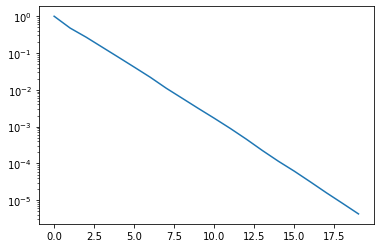

In [8]:
from scipy.sparse.linalg import gmres

rand = np.random.RandomState(0)

dim = 1000

w = np.linspace(0.1, 1, dim)

A = np.diag(w)
b = rand.randn(dim)
np.linalg.cond(A)

x, V = fom(A, b, m_max=20)

We can observe nice exponential convergence. Indeed, after just 17 iterations our relative residual is around $10^{-5}$. Hence, instead of a 1000 x 1000 system we only needed to solve systems up to dimension 17 for a pretty good solution.

However, there are some caveats though. A careful observer will have seen already that we cheated a little bit in the code. We have established that theoretically in the FOM the projected right-hand side takes the form $\|r_0\| e_1$. However, in the implementation we compute the projection of the right-hand side $b$ explicitly. The reason is loss of numerical orthogonality. The columns of the matrix $V$ lose their orthogonality over time with catastrophic effects. Let's run FOM for 100 steps.




Let's make a plot of the matrix $M = V^TV$. Theoretically, its diagonal values should be one and all other values $0$. Let's check this.

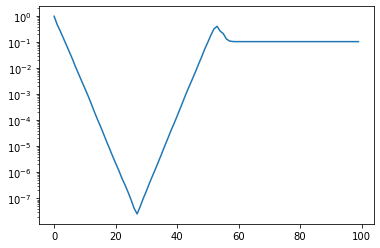

In [9]:
x, V = fom(A, b, m_max=100)

Up until around $m=30$ we converge nicely. But then the solution deteriorates again until we lose all our accuracy. Let's check the matrix $M = V^TV$. If $V$ is orthogonal then this matrix has ones on the diagonal and zeros everywhere else.

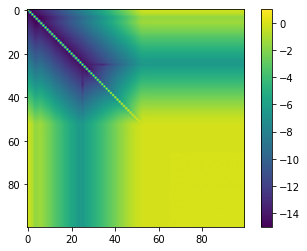

In [10]:
M = V.T @ V

plt.imshow(np.log10(np.abs(M)), vmin=-15, vmax=1)
plt.colorbar()

This is pretty bad. We completely lose orthogonality. The issue is the way in which we implemented the orthogonalisation. We used the classical Gram-Schmidt algorithm to do this, which is often taught in theoretical text books, but is not numerically stable. There are ways to stabilise the orthogonalisation by using for example modified Gram-Schmidt and introduing reorthogonalisation from time to ime. We are not going to discuss these techniques here.